In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
from typing import Dict, Text
import pycountry_convert as pc
import pycountry
import json
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

c:\Users\vijay.rameshkumar\Anaconda3\envs\myenv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\vijay.rameshkumar\Anaconda3\envs\myenv\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\vijay.rameshkumar\Anaconda3\envs\myenv\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df = pd.read_csv('Datasets/full_ml_training_data_2022-06-21_1655773206777.csv')

supplier_cols = ['projects__name', 'sample_pulls__country', 'sample_pulls__language', 
'sample_pulls__cost_per_interview', 'sample_pulls__industry', 'sample_pulls__sample_type', 
'quote_average_cpi', 'projects__study_types', 'suppliers__ref', 'effective_disposition']

df = df[supplier_cols]

In [3]:
get_continent = lambda x: pc.convert_continent_code_to_continent_name(pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(x))).lower().replace(" ", "-")

df['continents'] = df.sample_pulls__country.str.upper().apply(get_continent)

In [4]:
print(df.isnull().sum().sum())

df.fillna(0, inplace=True)

0


# 1. Inferential Analysis

In [5]:
print("Total Records : ", df.shape[0])

total_records = df.shape[0]

print(f"number of unique_countries : {df.sample_pulls__country.nunique()}")
print(f"number of unique_languages : {df.sample_pulls__language.nunique()}")
print(f"number of unique_countries - language Combinations : {df.sample_pulls__country.nunique() * df.sample_pulls__language.nunique()}")

Total Records :  2888057
number of unique_countries : 53
number of unique_languages : 26
number of unique_countries - language Combinations : 1378


In [6]:
us_can_eng = df[(df.sample_pulls__country == 'usa') & (df.sample_pulls__language == 'eng')].shape[0] + df[(df.sample_pulls__country == 'can') & (df.sample_pulls__language == 'eng')].shape[0]
us_can_all_lang = df[(df.sample_pulls__country == 'usa') | (df.sample_pulls__country == 'can')].shape[0]

print(f"total records we're having in src dataset : {total_records}")

print(f"\nWithout US & CAN we'll be having : {total_records - us_can_all_lang} records")
print(f"US & CAN - ALL records perc : {round(((us_can_all_lang)/total_records)*100, 2)}%")
print(f"All countries without US & CAN : {round(((total_records - us_can_all_lang)/total_records)*100,2)}%")

print(f"\nWithout US & CAN For ENG Language we'll be having: {total_records - us_can_eng} records")
print(f"US & CAN for ENG Language records perc : {round(((us_can_eng)/total_records)*100, 2)}%")
print(f"Other Countries & All Language records perc : {round(((total_records - us_can_eng)/total_records)*100, 2)}%")


total records we're having in src dataset : 2888057

Without US & CAN we'll be having : 958756 records
US & CAN - ALL records perc : 66.8%
All countries without US & CAN : 33.2%

Without US & CAN For ENG Language we'll be having: 965214 records
US & CAN for ENG Language records perc : 66.58%
Other Countries & All Language records perc : 33.42%


In [7]:
df.columns

Index(['projects__name', 'sample_pulls__country', 'sample_pulls__language',
       'sample_pulls__cost_per_interview', 'sample_pulls__industry',
       'sample_pulls__sample_type', 'quote_average_cpi',
       'projects__study_types', 'suppliers__ref', 'effective_disposition',
       'continents'],
      dtype='object')

In [8]:
df[df.continents == 'africa'].sample_pulls__country.unique()

array(['egy', 'ken', 'nga', 'zaf'], dtype=object)

# 2. Continent Level Distribution

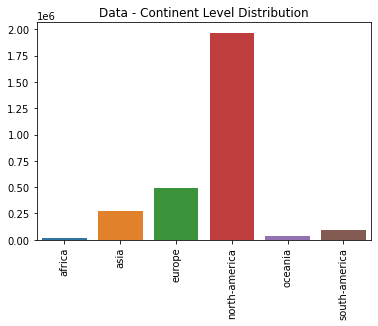

In [9]:
continent_level_stats = df.groupby(['continents']).projects__name.count().reset_index(name='record_count')

# sns.set(rc={"figure.figsize":(20, 10)})
sns.barplot(x=continent_level_stats.continents.values.tolist(), y=continent_level_stats.record_count.values.tolist()).set_title('Data - Continent Level Distribution')
plt.xticks(rotation=90)
plt.show()

# 3. Country Level Distribution

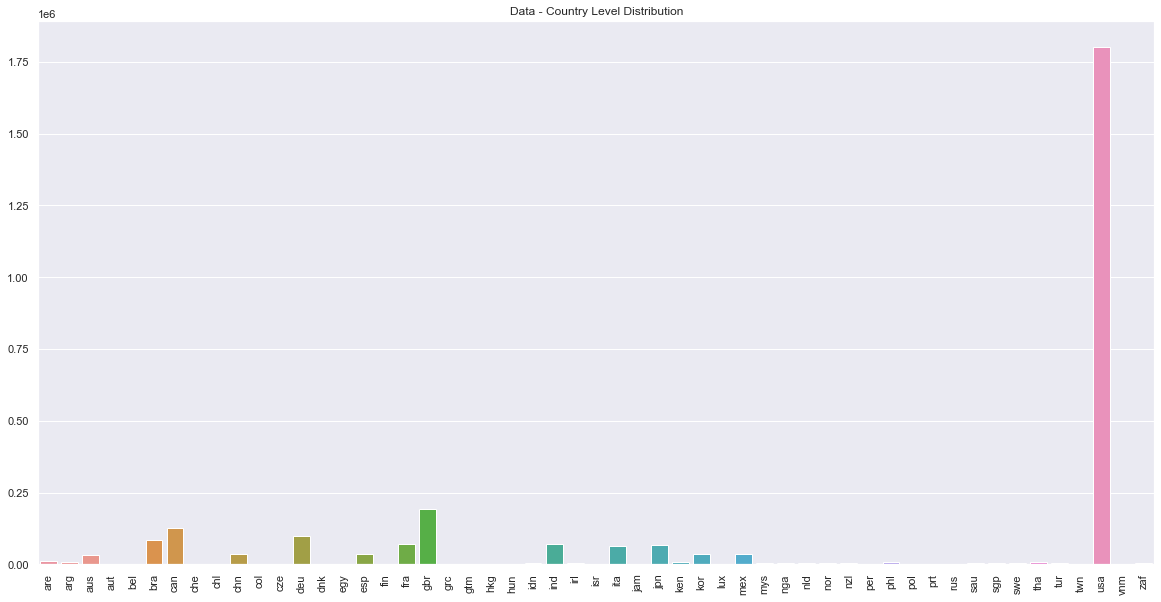

In [10]:
country_level_stats = df.groupby(['sample_pulls__country']).projects__name.count().reset_index(name='record_count')

sns.set(rc={"figure.figsize":(20, 10)})
sns.barplot(x=country_level_stats.sample_pulls__country.values.tolist(), y=country_level_stats.record_count.values.tolist()).set_title('Data - Country Level Distribution')
plt.xticks(rotation=90)
plt.show()

# 4. Country_Lang Level Data Distribution

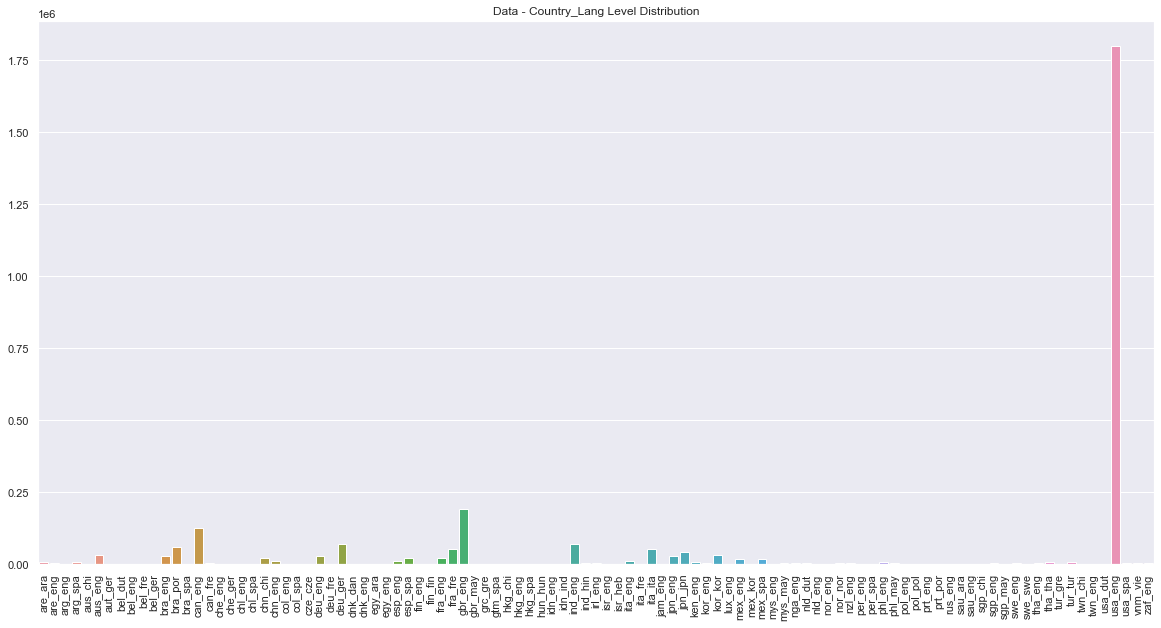

In [11]:
country_lang_level_stats = df.groupby(['sample_pulls__country', 'sample_pulls__language']).projects__name.count().reset_index(name='record_count')
country_lang_level_stats['cntry_lang'] = country_lang_level_stats['sample_pulls__country'] + "_" + country_lang_level_stats['sample_pulls__language']

sns.set(rc={"figure.figsize":(20, 10)})
sns.barplot(x=country_lang_level_stats.cntry_lang.values.tolist(), y=country_lang_level_stats.record_count.values.tolist()).set_title('Data - Country_Lang Level Distribution')
plt.xticks(rotation=90)
plt.show()

# 5. Data Transformation

## 5.1 Study_Subject Transformation

In [12]:
from collections import ChainMap
import pandas as pd
import ast 

cn = 'projects__study_types'

def map_study_id(x):
    a = {
        "40165df2-2e90-421b-81a7-92d6de784eeb": "B2B",
        "40bfbdc8-e328-44a2-8d99-91779ee7af52": "Community",
        "58ce16af-4615-4c15-b50a-bc3b9f8782af": "Consumer Study",
        "a452991e-25f9-4b8d-a988-780185bb79dc": "Healthcare",
        "0ca996b8-395e-4c9e-966e-017b73fa3c10": "Music Study",
        "7ad4fa71-ef64-46ac-8b50-e1430c8a7b07": "Product Testing",
        "b6d2d721-4017-4289-b869-7269a3339ebd": "Recruit"
    }

    return a[x]

def map_subject_id(lst):
    b = {
        "d13e78ef-48ed-46ea-9aec-12950a164c84":"banking_financial",
        "35b79ac1-9b3a-4752-b58b-aa866b098090":"biotech_pharmaceutical",
        "0c325fe2-6266-4c37-b5be-bc6328197a73":"corporate_travel",
        "859d0917-e6d1-4e02-9f89-7eda7a874975":"fulfillment",
        "79ef05f1-4dac-45f1-814e-a4eeb8155743":"hr",
        "bc5b9962-b316-45eb-998c-1c77d87e7fe0":"it_decision_maker",
        "d2d28831-b843-469c-82f7-33f4c0ba9e25":"legal",
        "c9f8f3a0-e399-4ecf-a0f1-566aef415723":"marketing_advertising",
        "6eeaf2c0-4a88-4c66-b088-8b6318d23b0d":"office_supplies",
        "53aed679-240e-462f-8951-bbd25ce2b9af":"operations",
        "bdeef761-bdae-4f20-9ab9-87eca2fab072":"real_estate_brokers_agents",
        "006c87f4-9287-4a21-85f1-62e0fcb5bfd2":"sales",
        "2bc5a048-0220-4789-a538-ab1959cb9546":"security",
        "1e01718c-d581-48f3-853f-695527bd2ccc":"service",
        "c1815203-0791-446a-bf88-81e1f624f18a":"software_hardware",
        "73d13a7b-4a67-43e8-80b1-0de01a06f555":"technology",
        "1f668cbd-197c-4caf-80b1-fc4b23cc6fc3":"transportation_logistics",
        "f3c73d6a-464e-4adf-a6fe-f66afc3db11f":"other",
        "8ce2e5d3-e5d4-494e-b406-5d53e8e7dbc3":"apparel_fashion ",
        "fc86e9da-c494-46c1-8477-d14db7f06272":"automotive_vehicle ",
        "e102c50c-e18c-45cb-bd7c-0a7b28e8e9ea":"bulletin_board_diary ",
        "e7d01b2b-2dab-4954-8864-e6ff621f844f":"commuting_frequent_travelers ",
        "27ee89ea-2e35-4be6-9210-be379bd5bd46":"electronics_large_appliance",
        "798e6098-76b7-4cf0-8f2f-5bc15167709c":"gaming",
        "51af3b9e-1d2d-4472-928e-ded86323f756":"kitchen_small_appliance",
        "e1a115c4-c711-4389-85f1-5146cbc590ef":"long_term",
        "a7718314-43dc-4683-a2bc-ec5b5801169a":"mattress_bedding ",
        "3aaa98f7-f8e0-4beb-adc9-4d468f243cb0":"mental_health_behavioral",
        "d294a03e-f79c-4ccb-9948-e143758600bd":"parenting_childcare",
        "115a186b-c926-4c7b-9d6f-8fb364e84627":"recruitment_panel",
        "ba7ad211-8661-4243-b0af-251c11fa314a":"shop_along_dining",
        "a9f57ded-68b5-470d-a137-e3ece282f3d5":"short_term",
        "fd5c7eef-2ab1-48f0-9156-3a94d2d63c58":"other",
        "f1623cdf-c1e7-4188-805a-e959ccb80e90":"automotive_transportation",
        "e550107c-28bf-438d-a7b7-587ebc0ff122":"community_insights ",
        "f45fe241-110c-44b5-a9f8-6cac0ebd68bf":"entertainment",
        "6a3517b9-b93d-4f74-9cfc-18c31ecfd28e":"finance_legal_insurance",
        "90d20f7c-da44-4c70-b736-e24e2aeae28a":"food_beverage",
        "5e7188c7-d4c1-426b-8c09-e3e2d33fc4b5":"grooming_cosmetics",
        "a337fdf6-1dc3-4418-9091-bbd3247a5883":"household",
        "bc193f05-1771-4544-b72e-a2e99c1a1823":"news_print_media",
        "8364dc15-8794-4289-a821-e5115187e579":"nutrition_wellness_fitness",
        "825aaab6-7691-4238-b132-0b3a9e6db01b":"pets_animal",
        "8541642e-2020-4810-aeca-555b826a6e3b":"political",
        "a7e9a929-2565-4b90-bc4a-66f757b8f584":"political_civic_services",
        "4830f8e9-5c9b-4492-8e12-e909f8f12f22":"print_social_media",
        "8a6d75b5-7609-4be1-aa4e-37ed2a1870f2":"realestate_construction",
        "a1e5507e-dc92-4a20-91e0-538167a68b03":"shopping_ecommerce ",
        "9421c5f2-1ac7-4000-8b9a-c7d0afe9c9f0":"social_media",
        "61e25b42-46dd-41c1-b28a-2e3ed46db835":"sports_gambling",
        "97a74f67-2f72-466b-8584-8830fe000d75":"technology",
        "a62d7f91-59ed-45d8-b0ac-849ea56d911e":"tobacco_vaping ",
        "e7b86ff7-090b-4f25-b1f4-e0ac94c6d131":"travel",
        "a6d1da3c-a58e-4b7f-9a59-a40e7ea7a92b":"video_games_games_toys",
        "71927908-032c-4eb0-b7aa-4f37ee36c337":"other",
        "c3102234-f46c-4df8-8ee5-e4a1857484dc":"patient",
        "892c04c1-5882-49e0-8923-9ad0b027f67f":"pharmaceutical",
        "2fb3b064-49cc-4ac8-bb38-521352442988":"professional",
        "eeb127d9-ef6a-4829-b06f-6d7ca9b6809c":"other",
        "3a263828-d4c2-4283-8747-064944213cde":"long_form",
        "d4c6299b-19aa-42ce-821e-18ba9f4c7d74":"short",
        "aacec342-f98b-4e50-81bf-7d79b602f639":"other",
        "a0c26f95-1f15-4a26-93a0-1ebccd342fde":"apparel_fashion",
        "6aa0c31f-35bc-409a-bb0c-3bc2a00c1181":"appliance_home_improvement",
        "107af06a-242b-41f5-8ce3-c12db0f3e7b3":"app_online",
        "d780fe64-26ad-4d17-9fac-a37c751e1c08":"automotive_vehicle",
        "f0d2de5d-2233-4374-9b06-c25d0d720c23":"beauty_self_care",
        "91e53495-b403-45bf-ac35-327998e1f79b":"electronics",
        "c9e01dbd-e64d-4552-ae63-210156e49fab":"entertainment_media",
        "2df8da96-7905-4353-86b1-94f6726694f1":"food_beverage",
        "e9bb90fa-c4bb-47ea-89c9-dfb2ac79e3b2":"games_toys",
        "1f2b5133-0155-4651-899b-7890e29ad892":"household_home_care",
        "dc07d54f-deac-4505-919a-f2e307822ec8":"parenting_childcare",
        "e09cfe0f-48a1-40cb-bd41-64ce17e894b6":"pets_animal",
        "b0d3230f-bb2c-47a5-90df-7525d74aa8a4":"tobacco_vaping ",
        "4753d06b-e9e2-41c9-adf4-d91ed43266f9":"other",
        "4e989a79-5e86-464b-9683-ddab15af5de8":"double_opt_in",
        "c51a81e5-7e8c-4937-9b04-3d280151f0a5":"single_opt_in",
        "bef3c165-34d3-494a-8d3e-bff90a5d1571":"other",
    }

    return [b[x] for x in lst]


print(f'[{cn}]: Evaluating datatype (list)')
df[cn] = df[cn].apply(ast.literal_eval)

print(f'[{cn}]: Exploding into multiple rows')
df = df.explode(cn)


print(f'[projects__study_types_ids]: Creating and mapping ...')
df['projects__study_types_ids'] = df.apply(lambda x: map_study_id(x[cn]['id']), axis=1)

print(f'[projects__study_types_subject_ids]: Creating and mapping ...')
df['projects__study_types_subject_ids'] = df.apply(lambda x: map_subject_id(x[cn]['studySubjectIds']), axis=1)

[projects__study_types]: Evaluating datatype (list)
[projects__study_types]: Exploding into multiple rows
[projects__study_types_ids]: Creating and mapping ...
[projects__study_types_subject_ids]: Creating and mapping ...


In [13]:
print(f"before exploding subject wise {df.shape}")

df = df.explode('projects__study_types_subject_ids')

print(f"after exploding subject wise {df.shape}")

before exploding subject wise (2899562, 13)
after exploding subject wise (3378176, 13)


In [14]:
df = df[df.effective_disposition.isin(['complete', 'security_terminate', 'terminate', 'over_quota'])]

In [15]:
for col in df.columns:
    df[col] = df[col].apply(lambda x: x.strip() if type(x) == 'str' else x)

df['projects__study_types_ids'] = df['projects__study_types_ids'].str.lower().apply(lambda x: x.replace(" ", "_"))
df['projects__study_types_subject_ids'] = df['projects__study_types_subject_ids'].str.lower()

## 5.2 Continent_lang_study_subject

In [16]:
temp = df.groupby(['continents', 'sample_pulls__language', 'projects__study_types_ids', 'projects__study_types_subject_ids', 'suppliers__ref', 'effective_disposition']).effective_disposition.count().reset_index(name='counts')

f2 = pd.pivot_table(temp, values='counts', index=['continents', 'sample_pulls__language', 'projects__study_types_ids', 'projects__study_types_subject_ids','suppliers__ref'], columns='effective_disposition').fillna(0)

In [17]:
f2['weighted_quote_avg_cpi_median'] = df.groupby(['continents', 'sample_pulls__language', 'projects__study_types_ids', 'projects__study_types_subject_ids', 'suppliers__ref']).quote_average_cpi.median().values
f2['weighted_suppliers_median_cpi'] = df.groupby(['continents', 'sample_pulls__language', 'projects__study_types_ids', 'projects__study_types_subject_ids', 'suppliers__ref']).sample_pulls__cost_per_interview.median().values
f2['median_profit_per_respondent'] = f2['weighted_quote_avg_cpi_median'] - f2['weighted_suppliers_median_cpi']
f2['profit_%'] = (f2['median_profit_per_respondent'] / f2['weighted_quote_avg_cpi_median'])*100

f2['total_panelist'] = f2['complete'] + f2['over_quota'] + f2['security_terminate'] + f2['terminate']
f2['accepted_panelist'] = f2['complete'] + f2['over_quota']
f2['rejected_panelist'] = f2['security_terminate']+f2['terminate']
f2['weighted_suppliers_median_complete_ratio'] = (f2['accepted_panelist'] / f2['total_panelist'])

f2 = f2.reset_index()

f2 = f2.sort_values(by=['continents', 'sample_pulls__language',
       'projects__study_types_ids', 'projects__study_types_subject_ids', 
       'median_profit_per_respondent', 'weighted_suppliers_median_complete_ratio'], ascending=[True, True, True, True, False, False])

In [18]:
f2 = f2[['continents', 'sample_pulls__language', 'projects__study_types_ids', 'projects__study_types_subject_ids', 'suppliers__ref', 'median_profit_per_respondent', 'weighted_suppliers_median_complete_ratio']]
f2.head()

effective_disposition,continents,sample_pulls__language,projects__study_types_ids,projects__study_types_subject_ids,suppliers__ref,median_profit_per_respondent,weighted_suppliers_median_complete_ratio
0,africa,ara,b2b,other,271,14.857143,0.543478
1,africa,eng,b2b,it_decision_maker,271,16.076190,0.000000
3,africa,eng,consumer_study,finance_legal_insurance,271,3.814839,0.206678
8,africa,eng,consumer_study,finance_legal_insurance,601,3.814839,0.192698
5,africa,eng,consumer_study,finance_legal_insurance,537,3.814839,0.138657


In [19]:
f2.to_csv('dataset/01_continent_lang_study_subject_weighted_suppliers_average_profit.csv', index=False)

## 5.3 Continent_study

In [20]:
temp = df.groupby(['continents', 'projects__study_types_ids', 'suppliers__ref', 'effective_disposition']).effective_disposition.count().reset_index(name='counts')

f3 = pd.pivot_table(temp, values='counts', index=['continents', 'projects__study_types_ids', 'suppliers__ref'], columns='effective_disposition').fillna(0)

In [21]:
f3['weighted_quote_avg_cpi_median'] = df.groupby(['continents', 'projects__study_types_ids', 'suppliers__ref']).quote_average_cpi.median().values
f3['weighted_suppliers_median_cpi'] = df.groupby(['continents', 'projects__study_types_ids', 'suppliers__ref']).sample_pulls__cost_per_interview.median().values
f3['median_profit_per_respondent'] = f3['weighted_quote_avg_cpi_median'] - f3['weighted_suppliers_median_cpi']
f3['profit_%'] = (f3['median_profit_per_respondent'] / f3['weighted_quote_avg_cpi_median'])*100

f3['total_panelist'] = f3['complete'] + f3['over_quota'] + f3['security_terminate'] + f3['terminate']
f3['accepted_panelist'] = f3['complete'] + f3['over_quota']
f3['rejected_panelist'] = f3['security_terminate']+f3['terminate']
f3['weighted_suppliers_median_complete_ratio'] = (f3['accepted_panelist'] / f3['total_panelist'])

f3 = f3.reset_index()

f3 = f3.sort_values(by=['continents', 'projects__study_types_ids', 'median_profit_per_respondent', 
'weighted_suppliers_median_complete_ratio'], ascending=[True, True, False, False])

In [22]:
f3.to_csv('dataset/02_continent_study_weighted_suppliers_average_profit.csv', index=False)

## 5.4 Continent Level Supplier Ranking

In [23]:
temp = df.groupby(['continents', 'suppliers__ref', 'effective_disposition']).effective_disposition.count().reset_index(name='counts')

f4 = pd.pivot_table(temp, values='counts', index=['continents', 'suppliers__ref'], columns='effective_disposition').fillna(0)

In [24]:
f4['weighted_quote_avg_cpi_median'] = df.groupby(['continents', 'suppliers__ref']).quote_average_cpi.median().values
f4['weighted_suppliers_median_cpi'] = df.groupby(['continents', 'suppliers__ref']).sample_pulls__cost_per_interview.median().values
f4['median_profit_per_respondent'] = f4['weighted_quote_avg_cpi_median'] - f4['weighted_suppliers_median_cpi']
f4['profit_%'] = (f4['median_profit_per_respondent'] / f4['weighted_quote_avg_cpi_median'])*100

f4['total_panelist'] = f4['complete'] + f4['over_quota'] + f4['security_terminate'] + f4['terminate']
f4['accepted_panelist'] = f4['complete'] + f4['over_quota']
f4['rejected_panelist'] = f4['security_terminate']+f4['terminate']
f4['weighted_suppliers_median_complete_ratio'] = (f4['accepted_panelist'] / f4['total_panelist'])

f4 = f4.reset_index()

f4 = f4.sort_values(by=['continents', 'median_profit_per_respondent', 
'weighted_suppliers_median_complete_ratio'], ascending=[True, False, False])

In [25]:
f4.to_csv('dataset/03_continent_weighted_suppliers_average_profit.csv', index=False)

## 5.5 Global Level Supplier Ranking

In [26]:
temp = df.groupby(['suppliers__ref', 'effective_disposition']).effective_disposition.count().reset_index(name='counts')

f5 = pd.pivot_table(temp, values='counts', index=['suppliers__ref'], columns='effective_disposition').fillna(0)

In [27]:
f5['weighted_quote_avg_cpi_median'] = df.groupby(['suppliers__ref']).quote_average_cpi.median().values
f5['weighted_suppliers_median_cpi'] = df.groupby(['suppliers__ref']).sample_pulls__cost_per_interview.median().values
f5['median_profit_per_respondent'] = f5['weighted_quote_avg_cpi_median'] - f5['weighted_suppliers_median_cpi']
f5['profit_%'] = (f5['median_profit_per_respondent'] / f5['weighted_quote_avg_cpi_median'])*100

f5['total_panelist'] = f5['complete'] + f5['over_quota'] + f5['security_terminate'] + f5['terminate']
f5['accepted_panelist'] = f5['complete'] + f5['over_quota']
f5['rejected_panelist'] = f5['security_terminate']+f5['terminate']
f5['weighted_suppliers_median_complete_ratio'] = (f5['accepted_panelist'] / f5['total_panelist'])

f5 = f5.reset_index()

f5 = f5.sort_values(by=['median_profit_per_respondent', 
'weighted_suppliers_median_complete_ratio'], ascending=[False, False])

In [28]:
f5.to_csv('dataset/04_Global_weighted_suppliers_average_profit.csv', index=False)